In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import random

from scipy.sparse import csr_matrix

%load_ext rpy2.ipython

## Classic basic processing

In [2]:
# Load data: converted anndata from seurat obj via celloracle
adata = sc.read('../celloracle/cdk8.19_mouse_seurat_CO_notebook.h5ad')
# In this notebook, I use raw mRNA count as an input of Oracle object.
adata.X = adata.layers["raw_count"].copy()

In [3]:
# mark mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# cosmetical changes
adata.obs['cell_type_condition'] = adata.obs['predicted.CellTypes'].str.cat(adata.obs['condition'], sep="_")

In [4]:
#csr_matrix(adata.layers['raw_count'], dtype=np.float32).toarray()[:10, :10]
#checked if there're raw counts. And yep

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)

In [6]:
print(adata.shape)
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)

#Some genes were removed, not cells

(31447, 32285)
(31447, 26193)


In [7]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
#New layer for transformed data
adata.layers["norm_log1p"] = adata.X.copy()

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="orig.ident")

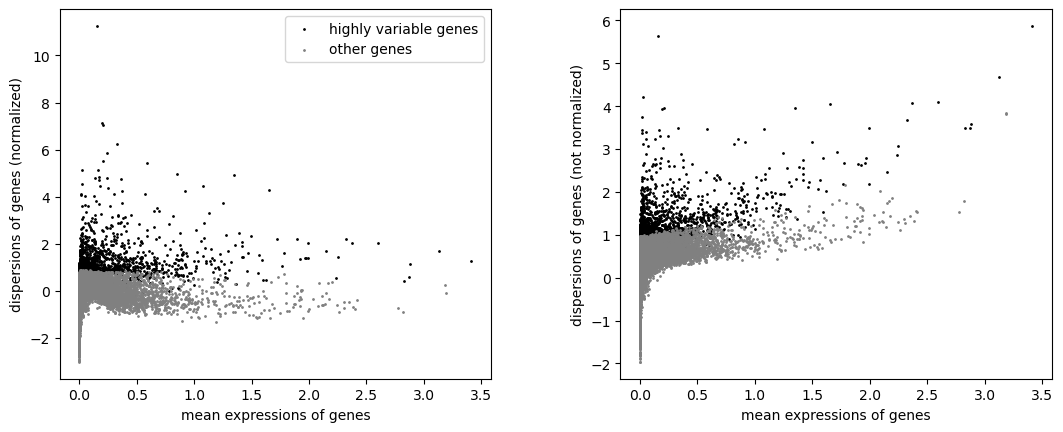

In [9]:
sc.pl.highly_variable_genes(adata)

In [10]:
sc.pp.scale(adata) # z-score
sc.tl.pca(adata)

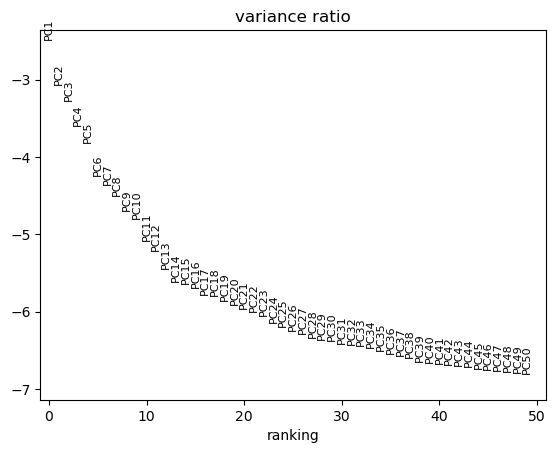

In [11]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

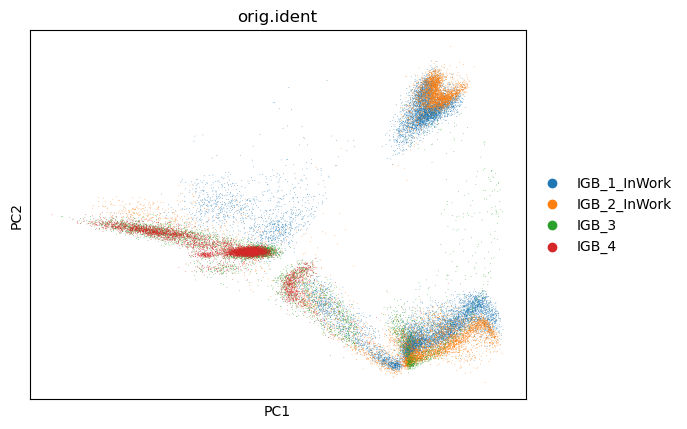

In [12]:
sc.pl.pca(
    adata,
    color=["orig.ident"], #orig.indent - samples feature
    dimensions=[(0, 1)],
    ncols=1,
    size=1,
)

In [13]:
# Run Harmony to correct PCA
sc.external.pp.harmony_integrate(adata, key='orig.ident', max_iter_harmony=20) #correction of batch effect

2025-04-14 12:54:42,320 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-14 12:55:23,763 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-14 12:55:24,298 - harmonypy - INFO - Iteration 1 of 20
2025-04-14 12:55:53,166 - harmonypy - INFO - Iteration 2 of 20
2025-04-14 12:56:18,675 - harmonypy - INFO - Iteration 3 of 20
2025-04-14 12:56:42,828 - harmonypy - INFO - Iteration 4 of 20
2025-04-14 12:57:06,373 - harmonypy - INFO - Iteration 5 of 20
2025-04-14 12:57:27,859 - harmonypy - INFO - Iteration 6 of 20
2025-04-14 12:57:39,098 - harmonypy - INFO - Iteration 7 of 20
2025-04-14 12:57:53,853 - harmonypy - INFO - Iteration 8 of 20
2025-04-14 12:58:07,244 - harmonypy - INFO - Converged after 8 iterations


In [14]:
# Calculate kNN graph
sc.pp.neighbors(adata, n_pcs=40, use_rep='X_pca_harmony')

# Calculate leiden clusters
sc.tl.leiden(adata)

# Calculate UMAP
sc.tl.umap(adata)

/tmp/ipykernel_1851379/403468874.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


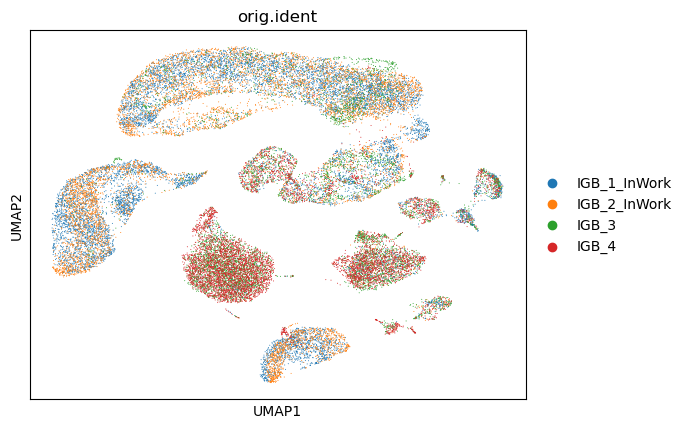

In [15]:
sc.pl.umap(
    adata,
    color="orig.ident",
    size=2,
)

In [16]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

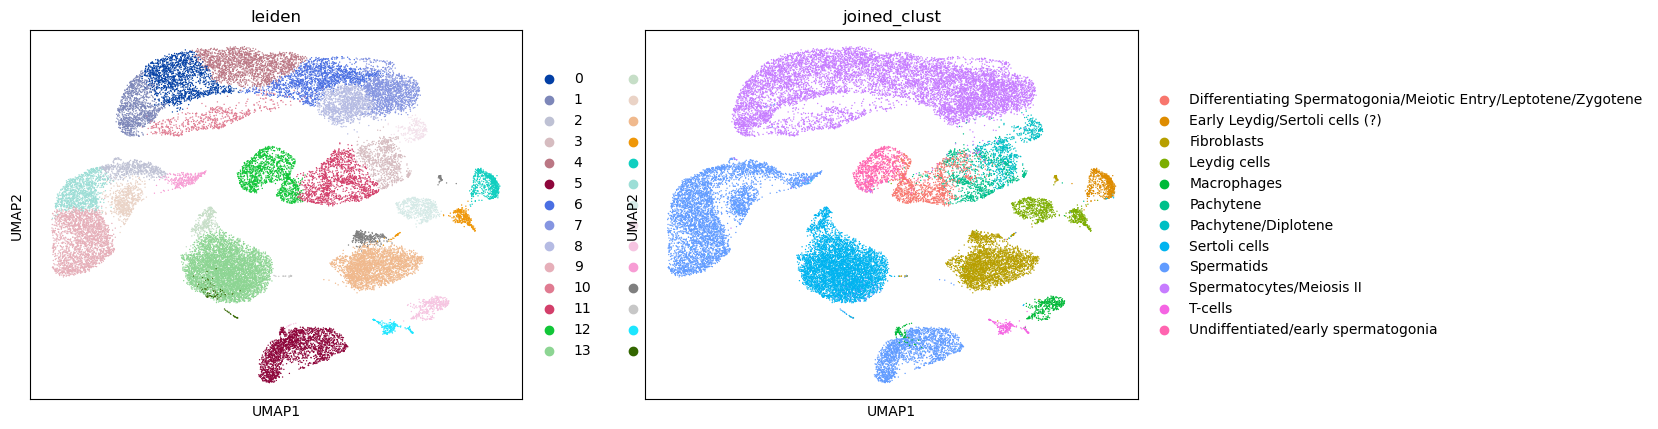

In [17]:
sc.pl.umap(adata, color=["leiden", "joined_clust"])

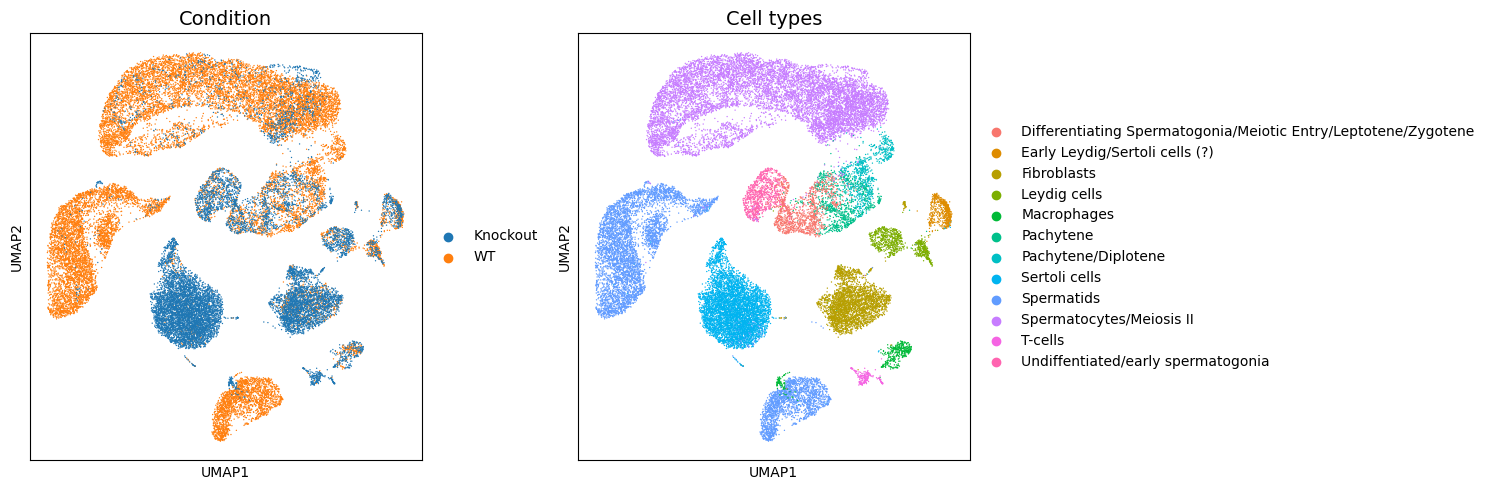

In [18]:
# Ensure Scanpy outputs two separate subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# First UMAP (condition)
sc.pl.umap(adata, color="condition", ax=axes[0], show=False)
axes[0].set_title("Condition", fontsize=14)

# Second UMAP (predicted.CellTypes) with a new title
sc.pl.umap(adata, color="joined_clust", ax=axes[1], show=False)
axes[1].set_title("Cell types", fontsize=14)

plt.tight_layout()
plt.show()

## Fixed pseudobulk analysis

In [19]:
import decoupler as dc

# DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import pydeseq2

In [20]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident', #== sample
    groups_col='joined_clust', #==cell type
    layer='raw_count',
    mode='sum', #default
    min_cells=10, #filtration
    min_counts=100 #filtration
)

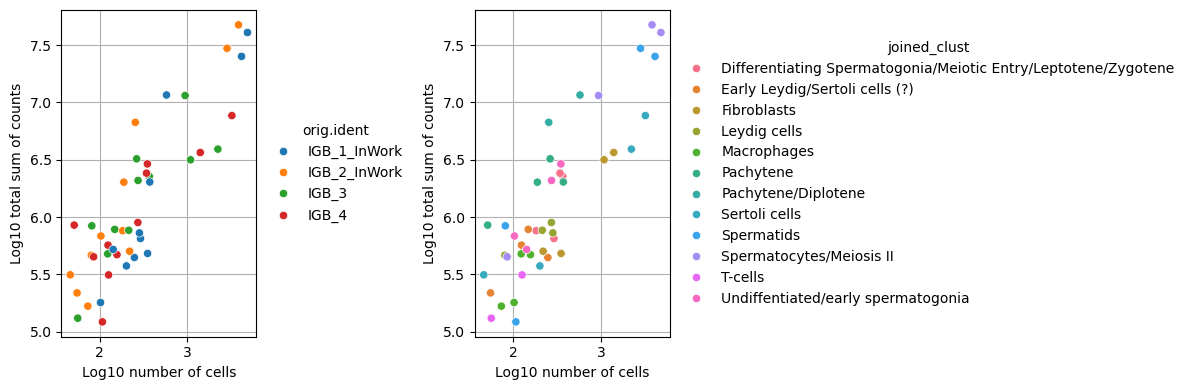

In [21]:
dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'joined_clust'], figsize=(12, 4))

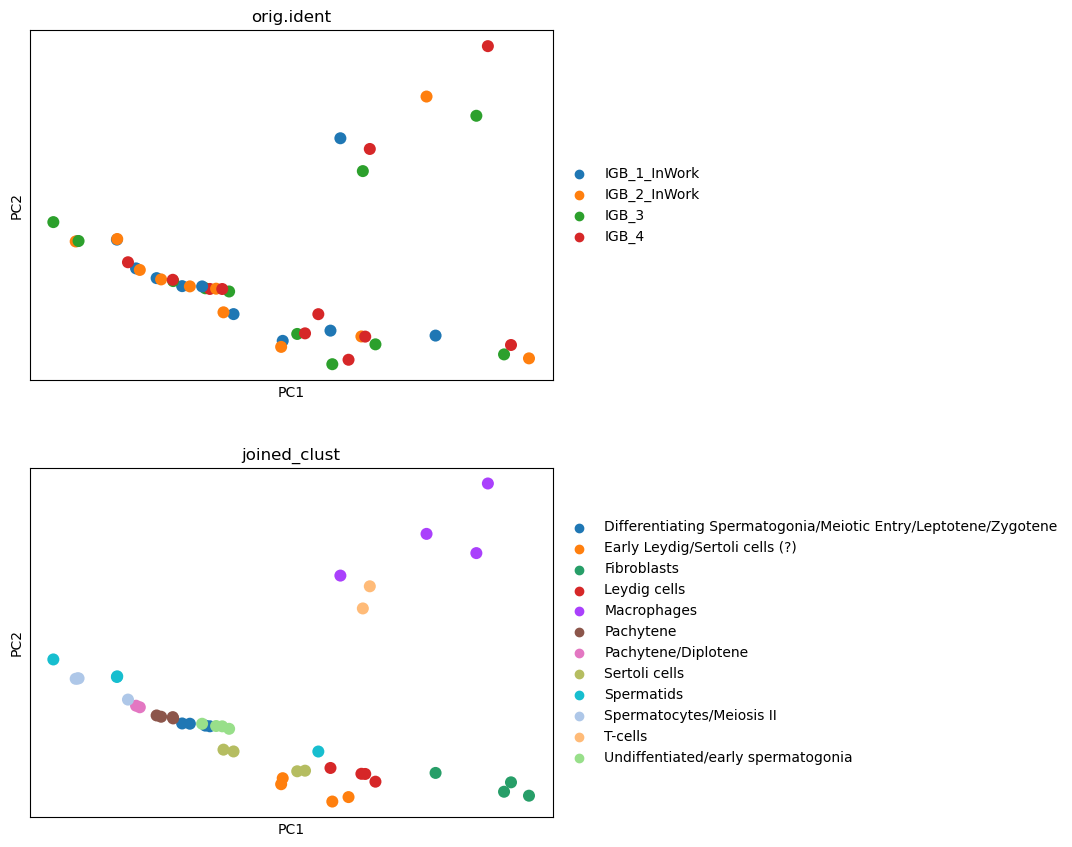

In [22]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

sc.pl.pca(pdata, color=['orig.ident', 'joined_clust'], ncols=1, size=300)
#We see distribution of samples on PCA according to cell types, not samples 

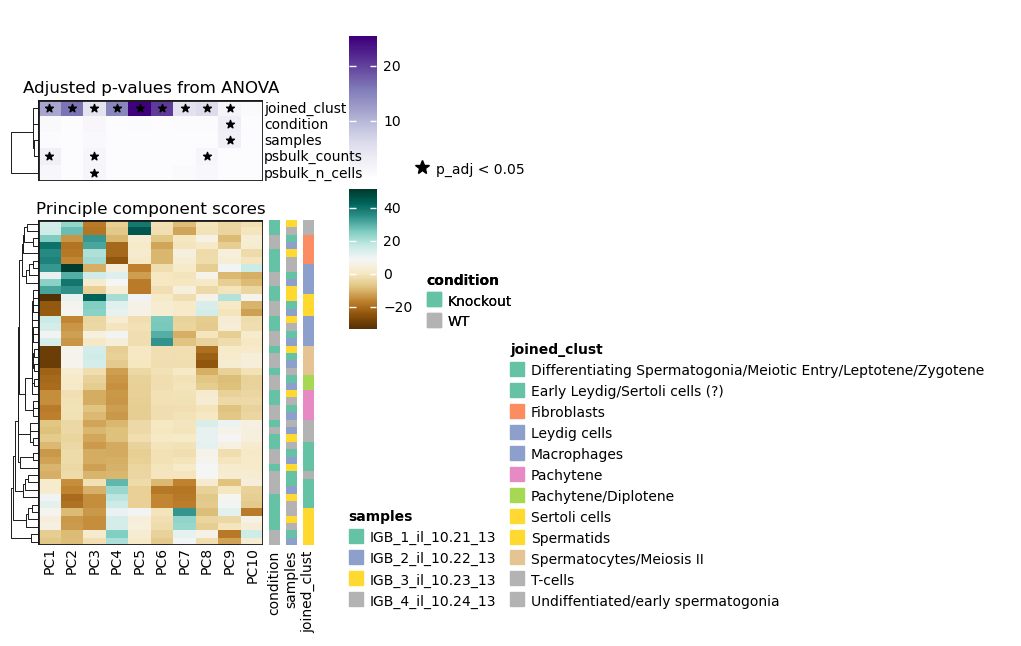

In [23]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['samples', 'condition', 'joined_clust', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'samples', 'joined_clust'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

#Meaning: PCA separates cell types, not condition

In [24]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv') #for intersection

set(pdata.obs['joined_clust'])

#Because python doesn't like special symbols
pdata.obs['joined_clust'] = pdata.obs['joined_clust'].astype(str)
pdata.obs.loc[pdata.obs['joined_clust'] == 'Early Leydig/Sertoli cells (?)', 'joined_clust'] = 'Early Leydig_or_Sertoli_cells'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene', 'joined_clust'] = 'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Pachytene/Diplotene', 'joined_clust'] = 'Pachytene_or_Diplotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Spermatocytes/Meiosis II', 'joined_clust'] = 'Spermatocytes_or_Meiosis_II'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Undiffentiated/early spermatogonia', 'joined_clust'] = 'Undiffentiated_or_Early_Spermatogonia'

In [25]:
#First version of visualisation func, without combining plots
'''
def full_pseudobulk(pdata, i, min_count, min_total_count): #where i - cell type annotation 
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=min_count, min_total_count=min_total_count)
    
    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(     # create an object
        counts=cell_type.X, #raw counts
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
        quiet=True)

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        print(dds.obs['condition'])
        return None
    
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
        quiet=True
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    #ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index
    
    plot = dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 4)
    )
    name = 'DE Analysis for ' + i.replace('_', ' ')
    plt.title(name) 
    
    significant = results_df[abs(results_df['padj']) < 0.05]
    significant = significant[significant['padj'] < 0.05]
    path = './pseudobulk_DEGs/sc_DEGs_'+i+'.csv'
    significant.to_csv(path, index=True)
    #print('DEGs for celltype', i, significant.index)
    #sc_bulk_intersection = list(set(significant.index) & set(bulk['x']))
    return plot
'''

In [26]:
#The last version - where all parameters are known and we want to combine all 8 volcano-plots
def full_pseudobulk(pdata, i, min_count, min_total_count, ax=None):  
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=min_count, min_total_count=min_total_count)
    
    # Filter by these genes
    cell_type = cell_type[:, genes].copy()

    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(
        counts=cell_type.X,
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
        quiet=True)

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        print(dds.obs['condition'])
        return None
    
    # Compute LFCs
    dds.deseq2()

    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
        quiet=True
    )

    ds_KO_vs_WT.summary()
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index

    # Pass ax to plot inside a given subplot
    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 4),
        ax=ax  
    )

    name = 'DE Analysis for ' + i.replace('_', ' ')
    ax.set_title(name) 

    # Save significant DEGs
    significant = results_df[abs(results_df['padj']) < 0.05]
    significant = significant[significant['padj'] < 0.05]
    path = f'./pseudobulk_DEGs/sc_DEGs_{i}.csv'
    significant.to_csv(path, index=True)

    return ax  


In [27]:
#Names of classes which are presented
set(pdata.obs['joined_clust'])

{'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene',
 'Early Leydig_or_Sertoli_cells',
 'Fibroblasts',
 'Leydig cells',
 'Macrophages',
 'Pachytene',
 'Pachytene_or_Diplotene',
 'Sertoli cells',
 'Spermatids',
 'Spermatocytes_or_Meiosis_II',
 'T-cells',
 'Undiffentiated_or_Early_Spermatogonia'}

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3,

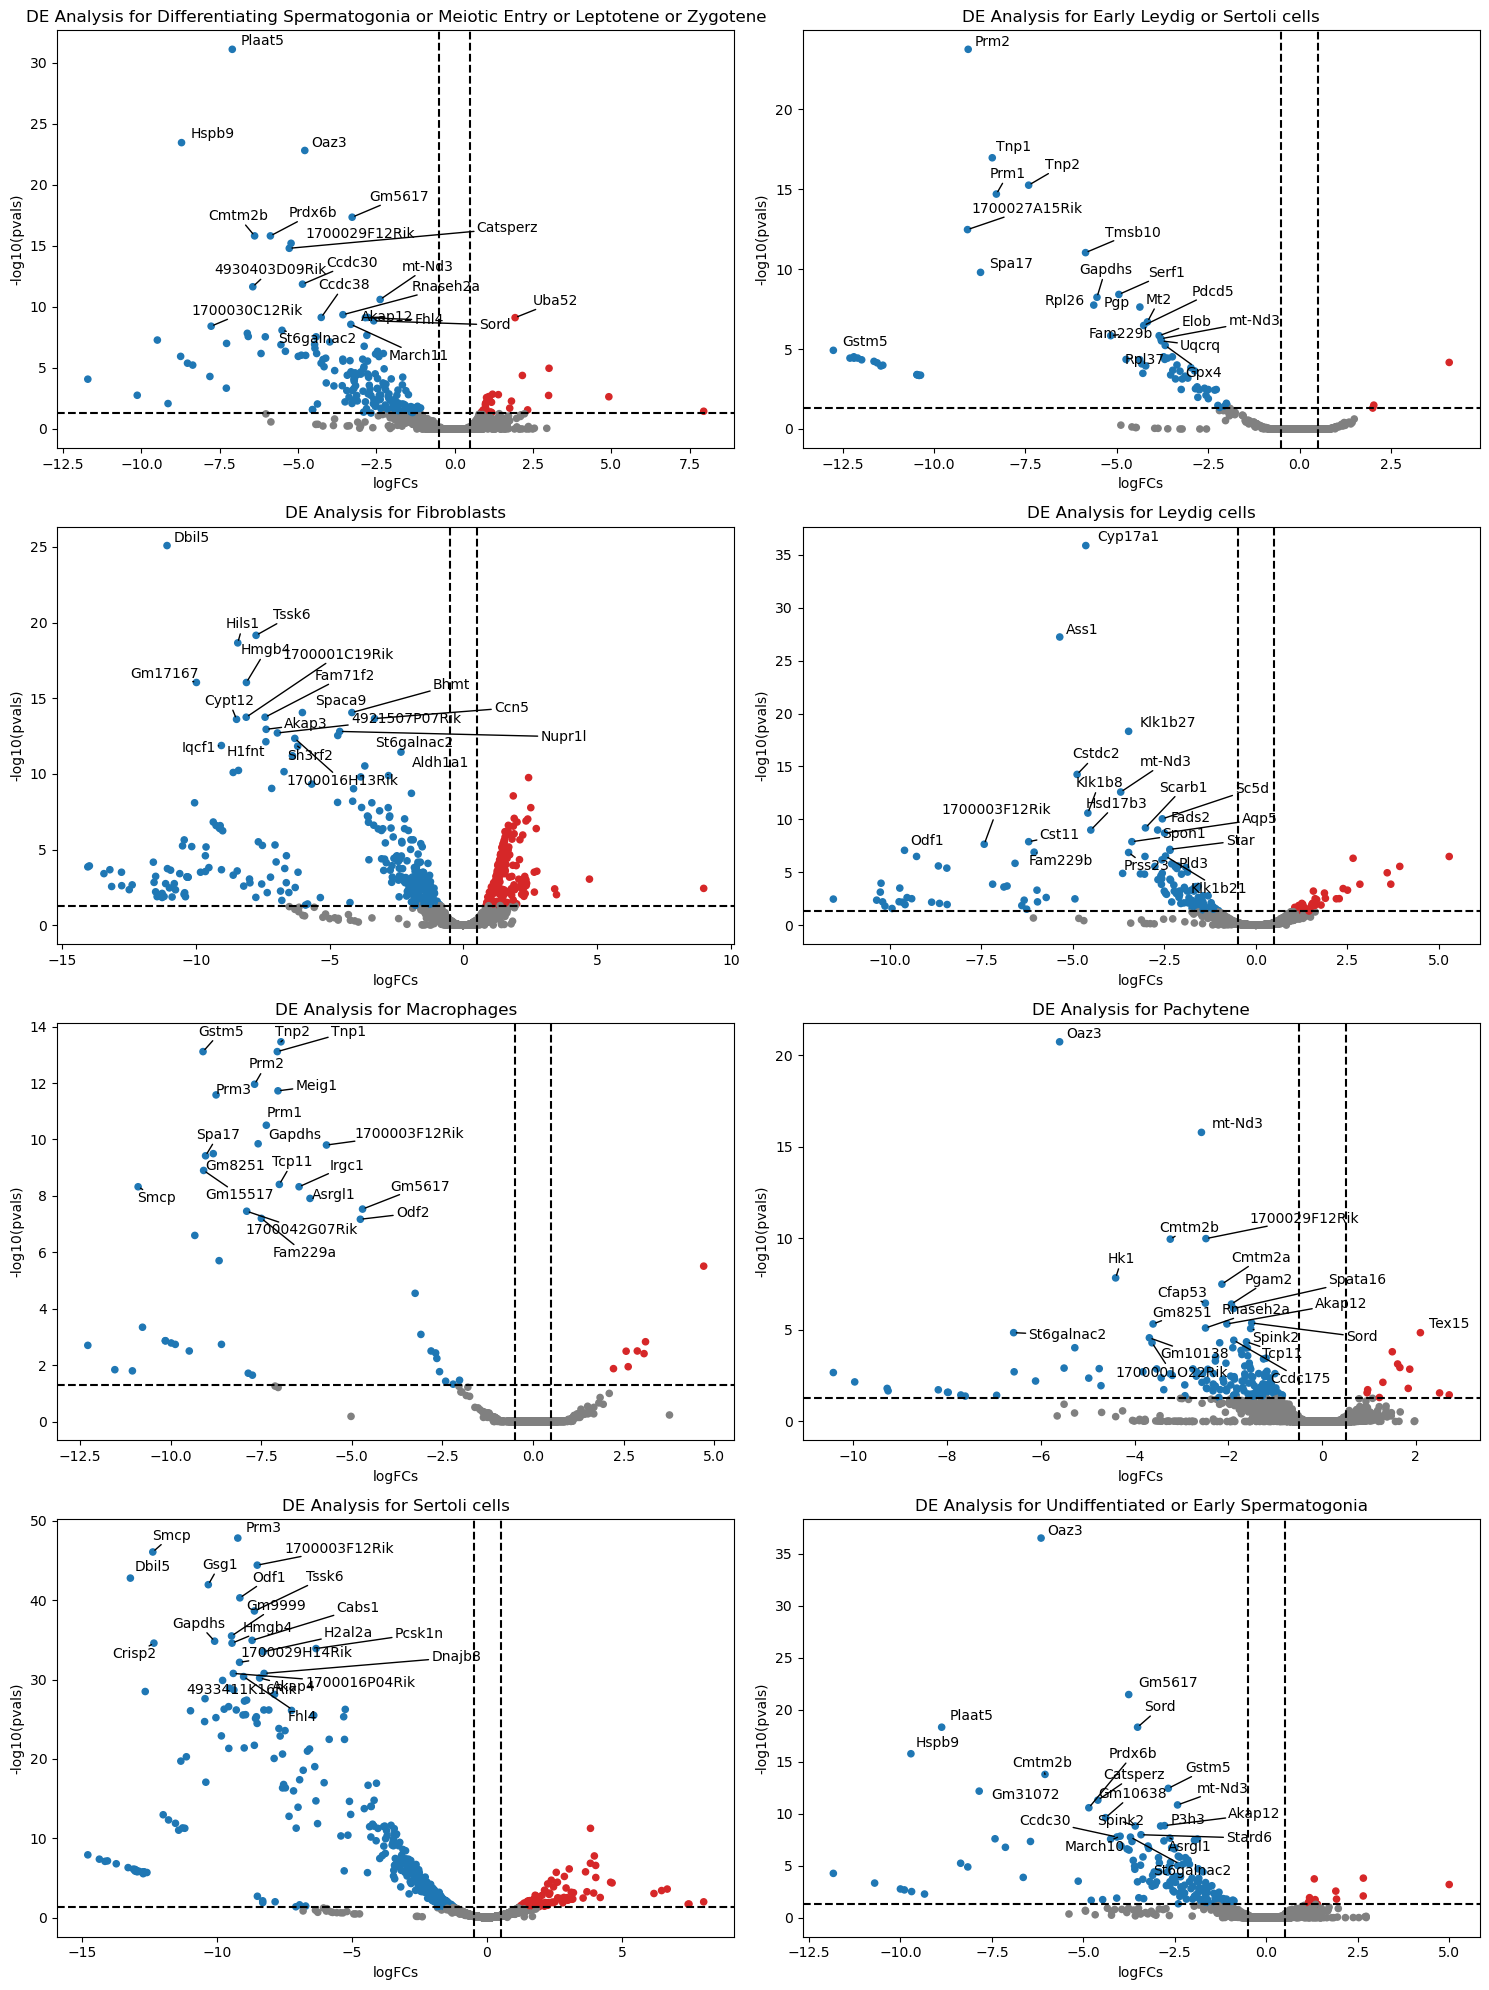

In [38]:
import matplotlib.pyplot as plt

## Combining [almost] all volcano-plots

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# List of parameters for each call
params = [
    ('Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene', 45, 60),
    ('Early Leydig_or_Sertoli_cells', 100, 150),
    ('Fibroblasts', 50, 65),
    ('Leydig cells', 45, 55),
    ('Macrophages', 55, 75),
    ('Pachytene', 30, 45),
    ('Sertoli cells', 100, 105),
    ('Undiffentiated_or_Early_Spermatogonia', 45, 55)
]

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Generate and plot each full_pseudobulk result
for ax, (cell_type, min_val, max_val) in zip(axes, params):
    full_pseudobulk(pdata, cell_type, min_val, max_val, ax=ax) 

# Adjust layout
plt.tight_layout()
plt.show()


In [40]:
#Here samples aren't full
full_pseudobulk(pdata, 'Pachytene_or_Diplotene', 10, 15)

There is no KO or WT samples for this cell type
IGB_1_InWork_Pachytene/Diplotene    WT
IGB_2_InWork_Pachytene/Diplotene    WT
Name: condition, dtype: category
Categories (1, object): ['WT']


In [44]:
#Here samples aren't full
full_pseudobulk(pdata, 'T-cells', 10, 20)

There is no KO or WT samples for this cell type
IGB_3_T-cells    Knockout
IGB_4_T-cells    Knockout
Name: condition, dtype: category
Categories (1, object): ['Knockout']


In [44]:
#For all cell types
cell_type = pdata.copy()
genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
cell_type = cell_type[:, genes].copy()
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(     # create an object
    counts=cell_type.X, #raw counts
    metadata=cell_type.obs,
    design='~condition',
    refit_cooks=True,
    inference=inference,
    quiet=True)

# Compute LFCs
dds.deseq2()
# Extract contrast between KO and WT
ds_KO_vs_WT = DeseqStats(
    dds,
    contrast=["condition", 'Knockout', 'WT'],
    inference=inference,
    quiet=True
)
# Compute Wald test
ds_KO_vs_WT.summary()
#ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
results_df = ds_KO_vs_WT.results_df
results_df.index = cell_type.var.index

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
Fitting dispersions...
... done in 1.62 seconds.

Fitting MAP dispersions...
... done in 1.65 seconds.

Fitting LFCs...
... done in 1.20 seconds.



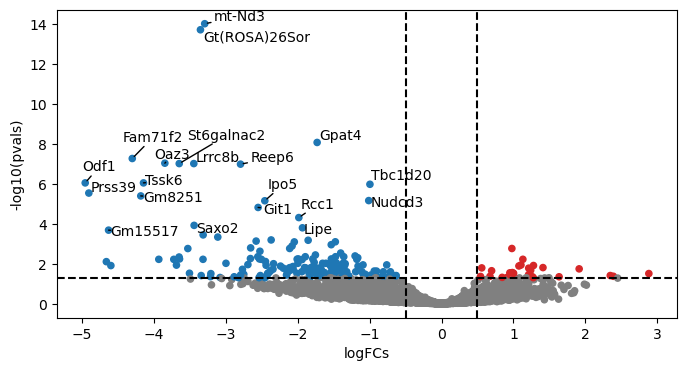

In [45]:
plot = dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)

In [49]:
significant = results_df[abs(results_df['padj']) < 0.05]
path = './pseudobulk_DEGs/sc_DEGs_all_celltypes.csv'
significant = significant[significant['padj'] < 0.05]
significant.to_csv(path, index=True)

## Meta analysis

Here we want to combine 8 obtained analyses from different celltypes into a new - meta-one.

In [26]:
import pymare
from pymare import meta_regression

In [27]:
def for_meta_pseudobulk(pdata, i, min_count, min_total_count): #where i - cell type annotation 
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=min_count, min_total_count=min_total_count)
    
    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(     # create an object
        counts=cell_type.X, #raw counts
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
        quiet=True)

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        print(dds.obs['condition'])
        return None
    
    # Compute LFCs
    dds.deseq2()
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
        quiet=True
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    #ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index
    results_df['variance'] = results_df['lfcSE']**2
    results_df = results_df[['log2FoldChange', 'variance']]
    
    results_df['intercept'] = list(dds.varm['LFC']['Intercept'])
    
    results_df.columns = ['L2FC_'+i, 'variance_'+i, 'intercept_'+i]
    
    return results_df

In [28]:
# Params are known because of the first iteration of vis. func.
params = [
    ('Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene', 45, 60),
    ('Early Leydig_or_Sertoli_cells', 100, 150),
    ('Fibroblasts', 50, 65),
    ('Leydig cells', 45, 55),
    ('Macrophages', 55, 75),
    ('Pachytene', 30, 45),
    ('Sertoli cells', 100, 105),
    ('Undiffentiated_or_Early_Spermatogonia', 45, 55)
]

all_l2fc = pd.DataFrame(index=range(len(pdata.var.index)),columns=range(8*3))
#8*3: 3 is for: l2fc, variance and intercept; 8 is for 8 cell types

counter = 0
for i in params:
    all_l2fc.rename(columns = {counter: 'L2FC_'+i[0], counter+1: 'variance_'+i[0], counter+2: 'intercept_'+i[0] }, inplace=True) 
    counter += 3

all_l2fc.index = pdata.var.index

In [29]:
for i in params:
    df = for_meta_pseudobulk(pdata, *i)
    all_l2fc.update(df)

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
/tmp/ipykernel_1851379/2729010206.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['intercept'] = list(dds.varm['LFC']['Intercept'])
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/si

In [30]:
all_l2fc_noNAN = all_l2fc.dropna()

In [31]:
lfc = []
var = []
inter = []
for k in range(0, 24, 3):
    lfc.append(k)

for k in range(1, 24, 3):
    var.append(k)
    
for k in range(2, 24, 3):
    inter.append(k)

#got indexes for lfc, variances and intercept

In [32]:
#initiate new df for plotting
volcano = pd.DataFrame(index=range(1),columns=range(2))
volcano.rename(columns = {0: 'estimate', 1: 'p-value'}, inplace=True) 

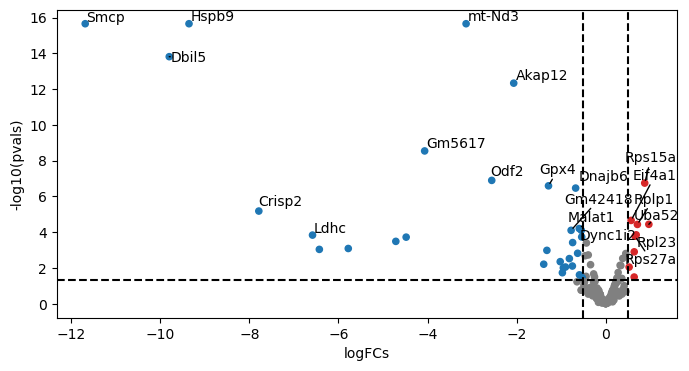

In [33]:
for index, row in all_l2fc_noNAN.iterrows():
    y = list(row[lfc])
    v = list(row[var])
    #X = list(row[inter])
    result = meta_regression(y, v, add_intercept=True, method='REML')
    
    result = result.to_df()
    
    volcano.loc[-1] = result[['estimate', 'p-value']].values[0]

    new_index = list(volcano.index)
    new_index[-1] = index
    volcano.index = new_index

#Volcano for genes which are expressed in all cell types
dc.plot_volcano_df(
    volcano,
    x='estimate',
    y='p-value',
    top=20,
    figsize=(8, 4)
)

In [34]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv')

In [35]:
bulk_all = pd.read_csv('DEGs_from_bulk_all_info.csv')

In [46]:
bulk_all[bulk_all['SYMBOL.y'] == 'Mt1']
#возрос в балке, упал в псевдобалке

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,SYMBOL.x,ENTREZID.x,GENENAME.x,SYMBOL.y,ENTREZID.y,GENENAME.y,GO,EVIDENCE,ONTOLOGY
1011,ENSMUSG00000031765,1934.554174,0.341818,0.070898,4.840897,0.000001,0.000035,Mt1,17748.0,metallothionein 1,Mt1,17748.0,metallothionein 1,GO:0005507,IDA,MF


In [47]:
bulk_all[bulk_all['SYMBOL.y'] == 'Jak1']
#упал в балке, возрос в псевдобалке

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,SYMBOL.x,ENTREZID.x,GENENAME.x,SYMBOL.y,ENTREZID.y,GENENAME.y,GO,EVIDENCE,ONTOLOGY
806,ENSMUSG00000028530,1630.698218,-0.190829,0.058855,-3.243567,0.00118,0.012869,Jak1,16451.0,Janus kinase 1,Jak1,16451.0,Janus kinase 1,GO:0000166,IEA,MF


In [48]:
bulk_all[bulk_all['SYMBOL.y'] == 'Akap12']
#возрос в балке, упал в псевдобалке

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,SYMBOL.x,ENTREZID.x,GENENAME.x,SYMBOL.y,ENTREZID.y,GENENAME.y,GO,EVIDENCE,ONTOLOGY
1298,ENSMUSG00000038587,535.017949,0.469612,0.087067,5.397778,6.747135e-08,0.000002,Akap12,83397.0,A kinase anchor protein 12,Akap12,83397.0,A kinase anchor protein 12,GO:0005516,IEA,MF


In [49]:
bulk_all[bulk_all['SYMBOL.y'] == 'Rpl23']
#вырос и в балке, и в псевдобалке

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,SYMBOL.x,ENTREZID.x,GENENAME.x,SYMBOL.y,ENTREZID.y,GENENAME.y,GO,EVIDENCE,ONTOLOGY
1917,ENSMUSG00000071415,5694.252394,0.166142,0.060661,2.729684,0.00634,0.04713,Rpl23,65019.0,ribosomal protein L23,Rpl23,65019.0,ribosomal protein L23,GO:0000122,ISO,BP


In [50]:
bulk_all[bulk_all['SYMBOL.y'] == 'Npm1']
#вырос и в балке, и в псевдобалке

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,SYMBOL.x,ENTREZID.x,GENENAME.x,SYMBOL.y,ENTREZID.y,GENENAME.y,GO,EVIDENCE,ONTOLOGY
1764,ENSMUSG00000057113,6266.21182,0.129121,0.046703,2.765542,0.005683,0.043413,Npm1,18148.0,nucleophosmin 1,Npm1,18148.0,nucleophosmin 1,GO:0000054,IBA,BP


In [42]:
# Пересечение балка и псевдлбалка
list(set(volcano[volcano['p-value'] < 0.05].index) & set(bulk['x']))

['Jak1', 'Akap12', 'Rpl23', 'Npm1', 'Mt1']

In [38]:
result = volcano[volcano['p-value'] < 0.05]
volcano[volcano['p-value'] < 0.05].shape

(56, 2)

In [43]:
print(result[result['estimate'] < 0].shape) #38 упавших генов
print(result[result['estimate'] > 0].shape) #18 возросших генов

(38, 2)
(18, 2)


## Check distribution of counts ~condition

In [101]:
for i in set(pdata.obs['joined_clust']):
    cell = pdata[pdata.obs['joined_clust'] == i].copy()
    print('sum of counts for ', i )
    print(pdata.obs[pdata.obs['joined_clust'] == i]['condition'])
    print(np.sum(cell.X, axis=1))

#Обычно для ингибирования каунтов больше, но есть типы клеток, где меньше. Вроде как, как раз те, где клетки умирали из-за ингибирования: сперматиды и пр.

sum of counts for  Early Leydig_or_Sertoli_maybe
IGB_1_InWork_Early Leydig/Sertoli cells (?)          WT
IGB_2_InWork_Early Leydig/Sertoli cells (?)          WT
IGB_3_Early Leydig/Sertoli cells (?)           Knockout
IGB_4_Early Leydig/Sertoli cells (?)           Knockout
Name: condition, dtype: category
Categories (2, object): ['Knockout', 'WT']
[444607. 218306. 781899. 569804.]
sum of counts for  Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene
IGB_1_InWork_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene          WT
IGB_2_InWork_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene          WT
IGB_3_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene           Knockout
IGB_4_Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene           Knockout
Name: condition, dtype: category
Categories (2, object): ['Knockout', 'WT']
[ 650683.  761314. 2265390. 2418926.]
sum of counts for  Fibroblasts
IGB_1_InWork_Fibroblasts     

In [94]:
fibroblasts = pdata[pdata.obs['joined_clust'] == 'Fibroblasts'].copy()
fibroblasts.obs

,orig.ident,joined_clust,seurat_clusters,samples,condition,nCount_prediction.score.CellTypes,nFeature_prediction.score.CellTypes,active_ident,psbulk_n_cells,psbulk_counts
IGB_1_InWork_Fibroblasts,IGB_1_InWork,Fibroblasts,4,IGB_1_il_10.21_13,WT,0,0,Fibroblasts,351.0,482121.0
IGB_2_InWork_Fibroblasts,IGB_2_InWork,Fibroblasts,4,IGB_2_il_10.22_13,WT,0,0,Fibroblasts,219.0,504130.0
IGB_3_Fibroblasts,IGB_3,Fibroblasts,4,IGB_3_il_10.23_13,Knockout,0,0,Fibroblasts,1086.0,3164315.0
IGB_4_Fibroblasts,IGB_4,Fibroblasts,4,IGB_4_il_10.24_13,Knockout,0,0,Fibroblasts,1401.0,3663479.0


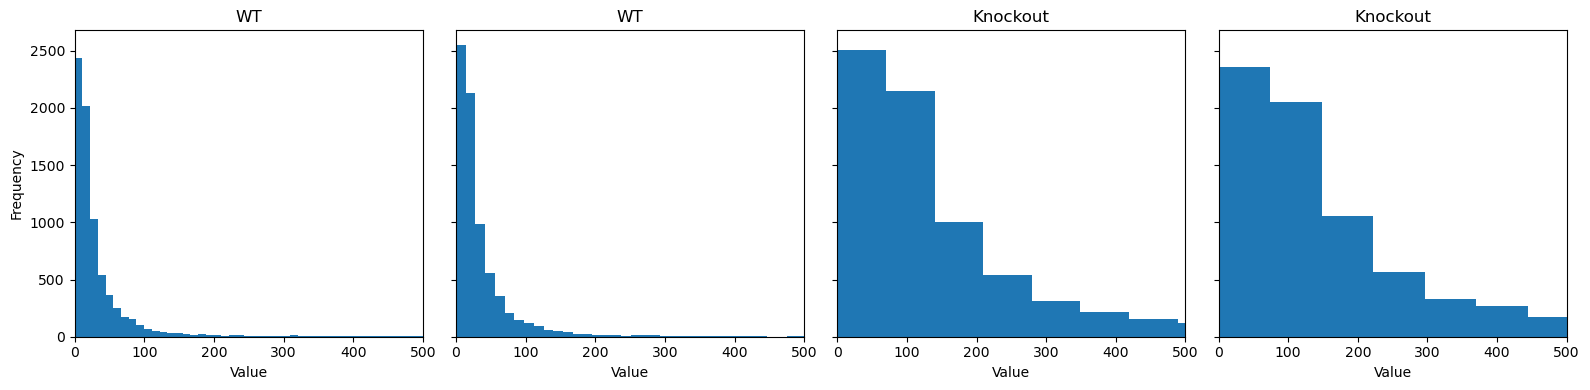

In [96]:
#Get only fibroblasts
fibroblasts = pdata[pdata.obs['joined_clust'] == 'Fibroblasts'].copy()

fibroblasts = fibroblasts[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(fibroblasts.X[i], bins=2000)

    ax.set_title(fibroblasts.obs['condition'][i])
    ax.set_xlabel('Value')
    ax.set_xlim([0, 500])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

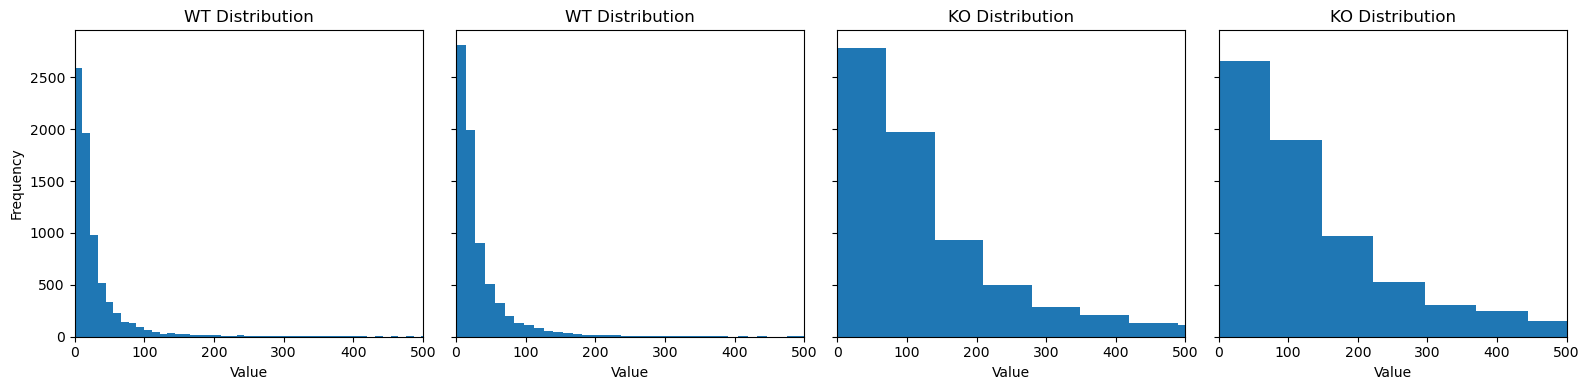

In [64]:
#Get only fibroblasts
fibroblasts = pdata[pdata.obs['joined_clust'] == 'Fibroblasts'].copy()

fibroblasts = fibroblasts[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(fibroblasts.X[i], bins=2000)

    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 500])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

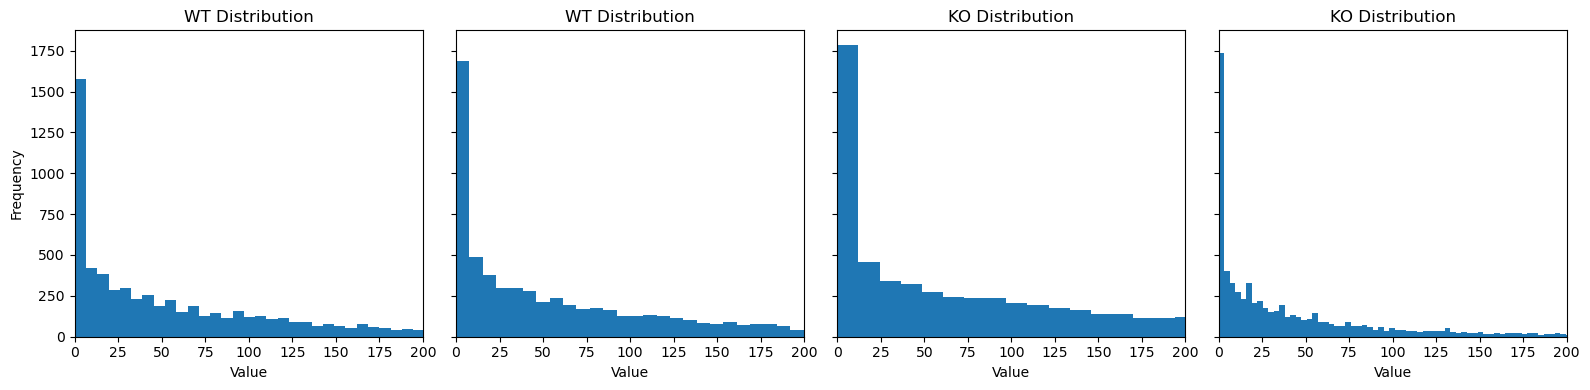

In [68]:
#Get only agranulocytes
pachytene = pdata[pdata.obs['joined_clust'] == 'Pachytene'].copy()

pachytene = pachytene[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(pachytene.X[i], bins=2000)
    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 200])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

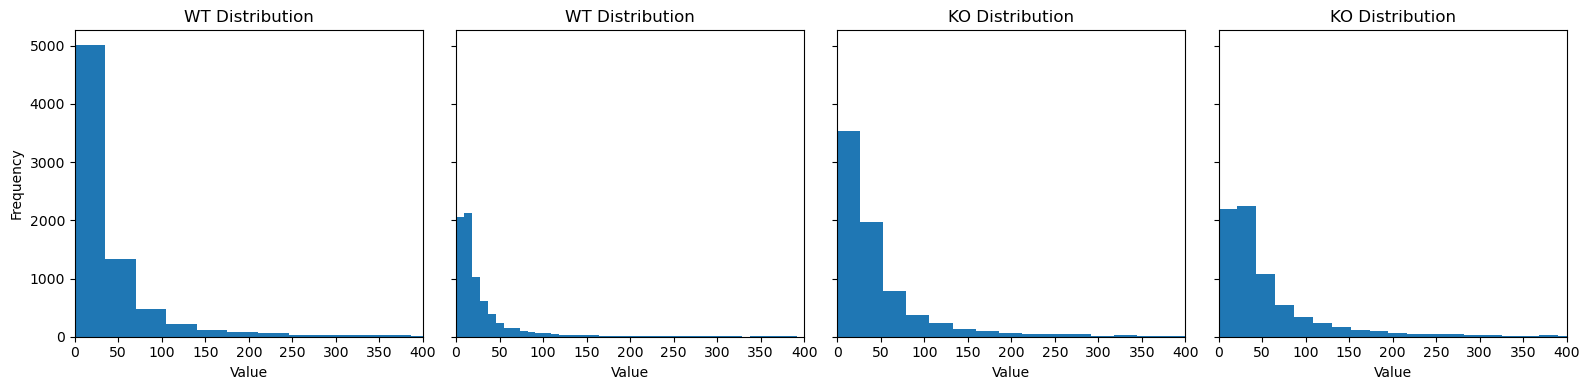

In [67]:
#Get only Leydig cells
leydig = pdata[pdata.obs['joined_clust'] == 'Leydig cells'].copy()
genes = dc.filter_by_expr(leydig, group='condition', min_count=10, min_total_count=15)

# Filter by these genes
leydig = leydig[:, genes].copy()

# Set up subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

# Create a histogram for each row
for i, ax in enumerate(axes):
    ax.hist(leydig.X[i], bins=2000)
    if i == 0 or i == 1:
        ax.set_title(f'WT Distribution')
    else: 
        ax.set_title(f'KO Distribution')
    ax.set_xlabel('Value')
    ax.set_xlim([0, 400])
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [327]:
import decoupler as dc

# DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [328]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident', #== sample
    groups_col='joined_clust', #==cell type
    layer='raw_count',
    mode='mean',
    min_cells=10, #filtration
    min_counts=100 #filtration
)

#Because python doesn't like special symbols
pdata.obs['joined_clust'] = pdata.obs['joined_clust'].astype(str)
pdata.obs.loc[pdata.obs['joined_clust'] == 'Early Leydig/Sertoli cells (?)', 'joined_clust'] = 'Early Leydig_or_Sertoli_maybe'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Differentiating Spermatogonia/Meiotic Entry/Leptotene/Zygotene', 'joined_clust'] = 'Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Pachytene/Diplotene', 'joined_clust'] = 'Pachytene_or_Diplotene'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Spermatocytes/Meiosis II', 'joined_clust'] = 'Spermatocytes_or_Meiosis_II'

pdata.obs.loc[pdata.obs['joined_clust'] == 'Undiffentiated/early spermatogonia', 'joined_clust'] = 'Undiffentiated_or_early_spermatogonia'


In [331]:
pdata.X

array([[0.0000000e+00, 0.0000000e+00, 5.4982819e-02, ..., 5.2783504e+00,
        2.8419244e+00, 6.7010307e-01],
       [5.4945056e-03, 0.0000000e+00, 1.7032968e-01, ..., 1.0412087e+01,
        5.2802196e+00, 7.1428573e-01],
       [1.0899182e-02, 0.0000000e+00, 2.4523161e-01, ..., 1.9956404e+01,
        8.0844688e+00, 1.4005450e+00],
       ...,
       [2.9126214e-02, 0.0000000e+00, 2.7184466e-01, ..., 1.1834951e+01,
        6.3009710e+00, 7.1844661e-01],
       [7.3260074e-03, 0.0000000e+00, 2.2710623e-01, ..., 2.1315018e+01,
        9.1941395e+00, 1.2197802e+00],
       [2.8653296e-03, 0.0000000e+00, 3.5816619e-01, ..., 1.6074499e+01,
        7.6246419e+00, 1.1146132e+00]], dtype=float32)

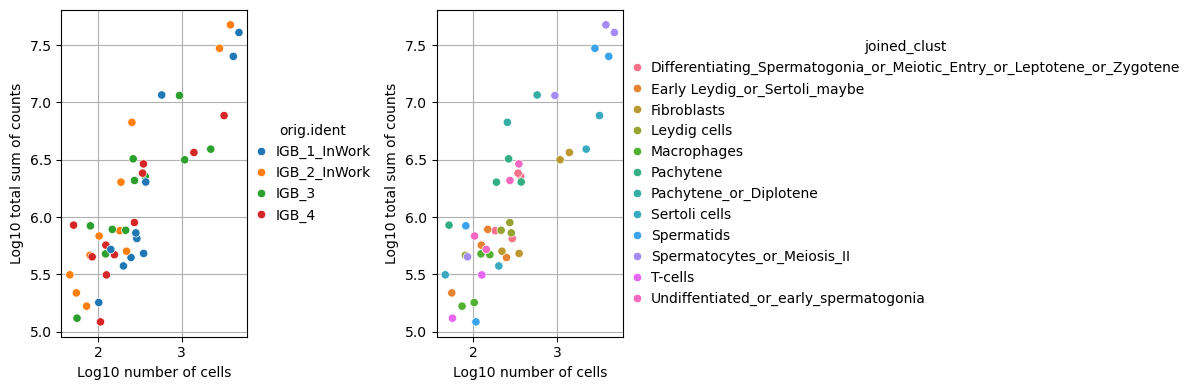

In [332]:
dc.plot_psbulk_samples(pdata, groupby=['orig.ident', 'joined_clust'], figsize=(12, 4))

In [333]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

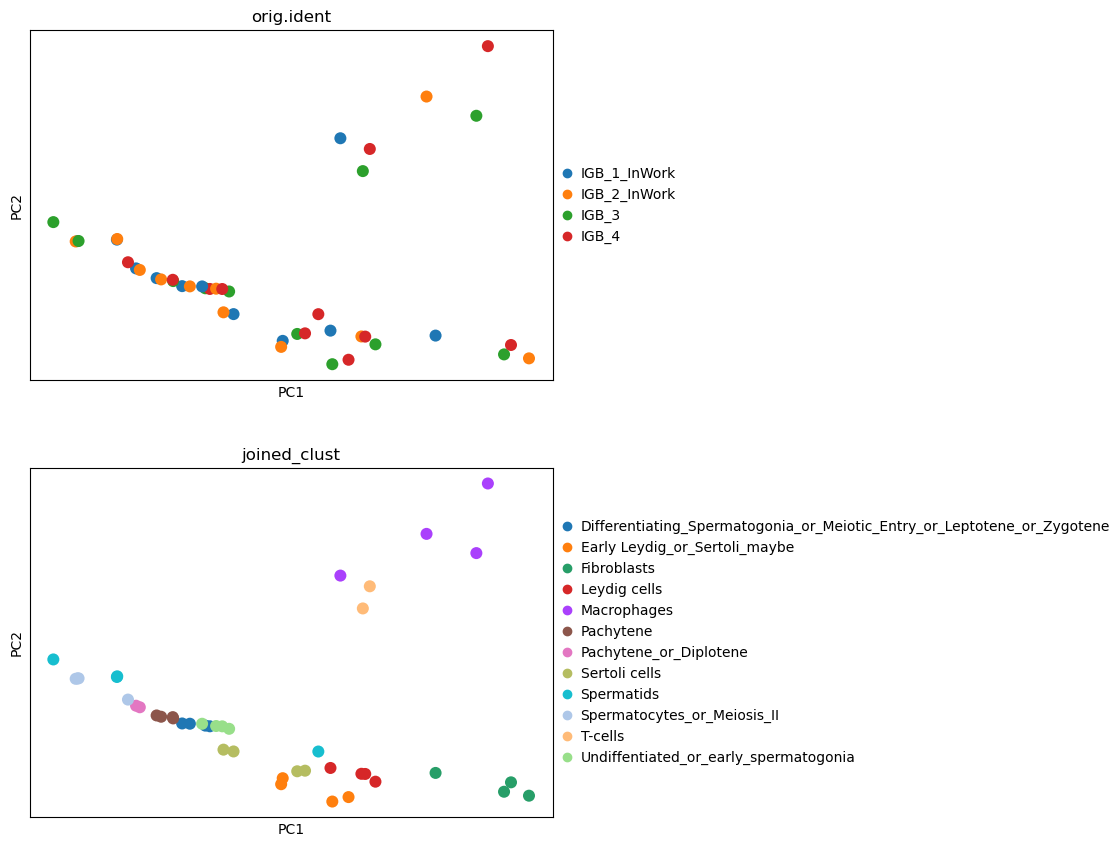

In [334]:
sc.pl.pca(pdata, color=['orig.ident', 'joined_clust'], ncols=1, size=300)
#We see distribution of samples on PCA according to cell types, not samples 

In [335]:
pdata.X

array([[0.0000000e+00, 0.0000000e+00, 5.4982819e-02, ..., 5.2783504e+00,
        2.8419244e+00, 6.7010307e-01],
       [5.4945056e-03, 0.0000000e+00, 1.7032968e-01, ..., 1.0412087e+01,
        5.2802196e+00, 7.1428573e-01],
       [1.0899182e-02, 0.0000000e+00, 2.4523161e-01, ..., 1.9956404e+01,
        8.0844688e+00, 1.4005450e+00],
       ...,
       [2.9126214e-02, 0.0000000e+00, 2.7184466e-01, ..., 1.1834951e+01,
        6.3009710e+00, 7.1844661e-01],
       [7.3260074e-03, 0.0000000e+00, 2.2710623e-01, ..., 2.1315018e+01,
        9.1941395e+00, 1.2197802e+00],
       [2.8653296e-03, 0.0000000e+00, 3.5816619e-01, ..., 1.6074499e+01,
        7.6246419e+00, 1.1146132e+00]], dtype=float32)

In [336]:
dc.get_metadata_associations(
    pdata,
    obs_keys = ['samples', 'condition', 'joined_clust', 'psbulk_n_cells', 'psbulk_counts'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)

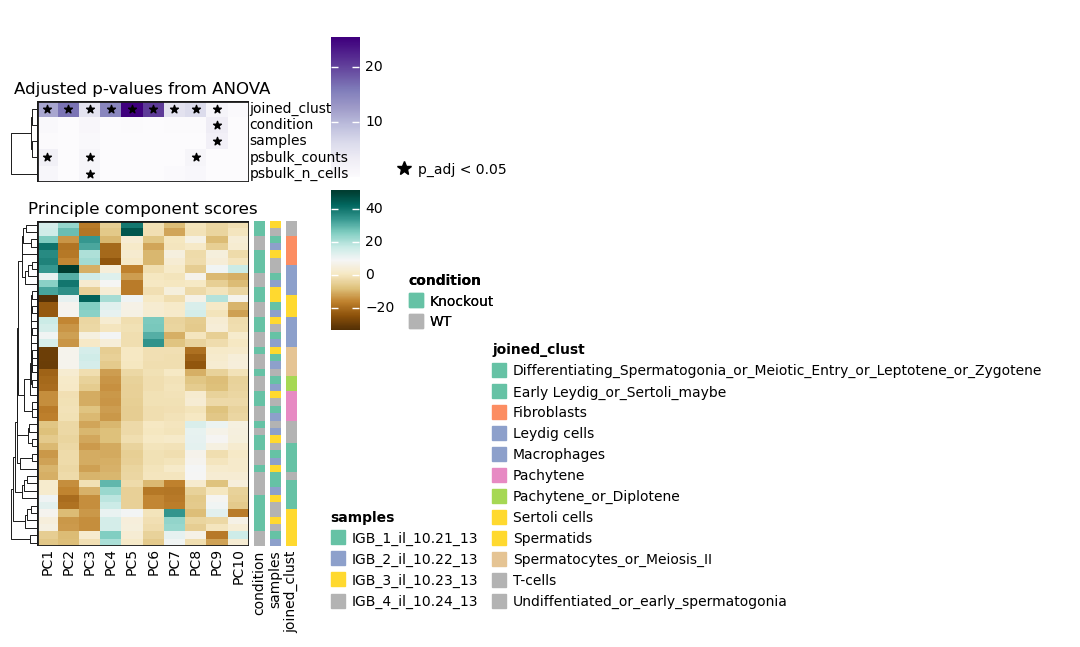

In [337]:
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['condition', 'samples', 'joined_clust'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

#Meaning: PCA separates cell types, not condition

In [338]:
bulk = pd.read_csv('DEGs_from_bulkRNAseq.csv')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.03 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Using None as control genes, passed at DeseqDataSet initialization


Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...
... done in 0.04 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     7.191546        0.841571  0.881145  0.955089  0.339533  0.950470
1     9.124206       -0.085309  0.798793 -0.106797  0.914950  0.963105
2    24.793904        0.224039  0.562197  0.398506  0.690257  0.950470
3     7.795417       -0.015059  0.835098 -0.018033  0.985612  0.985612
4   169.647220       -0.089474  0.451227 -0.198290  0.842818  0.950470
5    20.117214       -6.800780  1.583834 -4.293871  0.000018  0.000176
6     8.749322       -7.039029  2.478247 -2.840326  0.004507  0.030045
7    15.938521        0.829493  0.654865  1.266662  0.205276  0.821104
8     9.201918        0.412730  0.795423  0.518881  0.603844  0.950470
9    85.318795        0.148278  0.432873  0.342545  0.731941  0.950470
10  134.266229       -0.522559  0.407653 -1.281872  0.199888  0.821104
11   99.448816       -0.077612  0.425962 -0.182203  0.855423  0.950470
12  141.308707

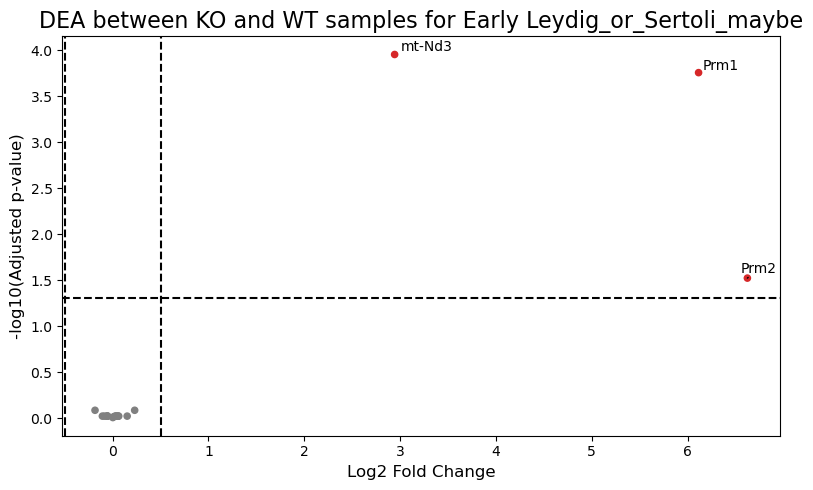

significantly DE genes for  Early Leydig_or_Sertoli_maybe , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.16 seconds.

Fitting LFCs...
... done in 0.05 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    8.212384       -0.709628  0.606913 -1.169243  0.242306  0.775397
1    9.598135       -0.174430  0.581069 -0.300188  0.764034  0.899938
2    9.917702       -0.076646  0.573434 -0.133662  0.893670  0.932525
3   18.419419       -1.258505  0.606722 -2.074270  0.038054  0.590108
4   10.457649       -0.027384  0.561246 -0.048791  0.961086  0.977330
5   13.224611       -0.570145  0.514536 -1.108075  0.267829  0.775397
6   19.591470       -0.357577  0.457059 -0.782344  0.434013  0.886749
7   15.134260       -0.563906  0.495803 -1.137358  0.255389  0.775397
8   11.461187       -1.080334  0.549626 -1.965582  0.049347  0.590108
9    8.539202        0.317919  0.615800  0.516269  0.605666  0.899938
10  14.239813        0.555509  0.525838  1.056426  0.290774  0.775397
11   8.241957        0.717791  0.652144  1.100664  0.271043  0.775397
12   9.324376        0.7582

... done in 0.18 seconds.



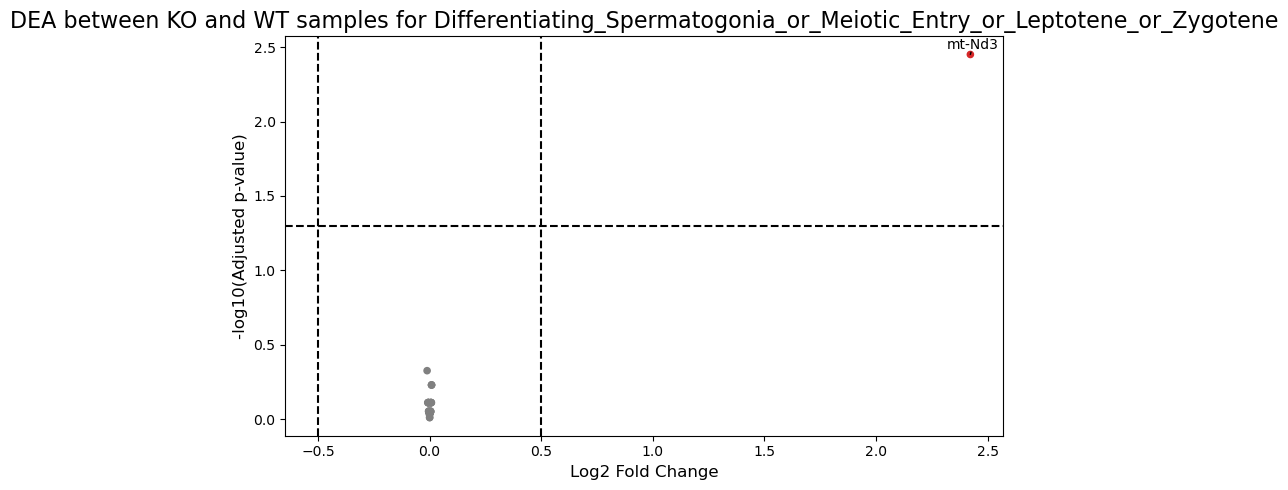

significantly DE genes for  Differentiating_Spermatogonia_or_Meiotic_Entry_or_Leptotene_or_Zygotene , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.03 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.01 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     7.500723        1.374129  0.848849  1.618814  0.105487  0.497297
1     6.382590        0.345303  0.782298  0.441395  0.658927  0.869784
2    30.675068       -0.117135  0.533111 -0.219720  0.826090  0.940033
3     7.894502        0.202454  0.728436  0.277929  0.781067  0.920543
4     8.551598       -0.068845  0.701585 -0.098128  0.921831  0.950638
5    45.191402       -1.939307  0.562873 -3.445371  0.000570  0.009410
6    15.150975       -1.344920  0.610681 -2.202327  0.027642  0.182439
7    10.998366       -0.878772  0.649639 -1.352708  0.176149  0.597541
8   112.210320       -1.127531  0.464085 -2.429578  0.015116  0.166281
9    22.343677       -7.161440  1.577031 -4.541088  0.000006  0.000185
10    7.200631        0.631802  0.778779  0.811273  0.417209  0.764883
11    8.564447        0.673353  0.733793  0.917633  0.358811  0.764883
12    6.029582

... done in 0.10 seconds.



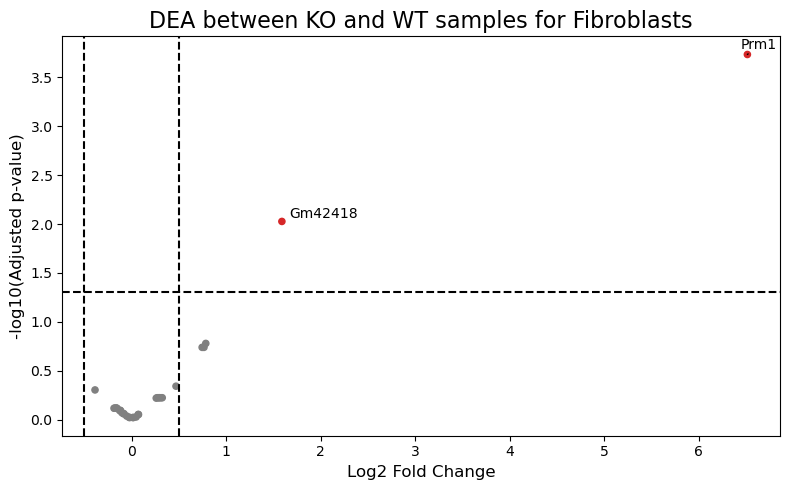

significantly DE genes for  Fibroblasts , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.11 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.03 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...


There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


... done in 0.13 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.07 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   10.106955       -0.218298  0.627245 -0.348026  0.727820  0.995475
1   10.720414       -0.189491  0.617039 -0.307097  0.758769  0.995475
2   11.431673       -0.354291  0.606133 -0.584510  0.558877  0.995475
3   12.928359       -0.169017  0.583766 -0.289529  0.772176  0.995475
4    8.901254       -0.278287  0.646483 -0.430463  0.666859  0.995475
..        ...             ...       ...       ...       ...       ...
84  22.893739       -0.241689  0.512324 -0.471752  0.637104  0.995475
85  15.621569       -0.156011  0.556369 -0.280410  0.779163  0.995475
86   9.063336       -2.602237  0.754482 -3.449039  0.000563  0.050070
87  18.853793       -0.231743  0.532679 -0.435052  0.663524  0.995475
88  13.095077        0.120545  0.586199  0.205639  0.837073  0.995475

[89 rows x 6 columns]


Fitting MAP LFCs...
... done in 0.39 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   10.106955    5.746433e-07  0.001354 -0.348026  0.727820  0.995475
1   10.720414    5.174238e-07  0.001356 -0.307097  0.758769  0.995475
2   11.431673    9.969067e-07  0.001375 -0.584510  0.558877  0.995475
3   12.928359    5.189351e-07  0.001367 -0.289529  0.772176  0.995475
4    8.901254    6.926379e-07  0.001359 -0.430463  0.666859  0.995475
..        ...             ...       ...       ...       ...       ...
84  22.893739    9.217689e-07  0.001405 -0.471752  0.637104  0.995475
85  15.621569    5.272976e-07  0.001373 -0.280410  0.779163  0.995475
86   9.063336    2.079536e+00  0.756909 -3.449039  0.000563  0.050070
87  18.853793    8.743511e-07  0.001392 -0.435052  0.663524  0.995475
88  13.095077   -3.627233e-07  0.001336  0.205639  0.837073  0.995475

[89 rows x 6 columns]


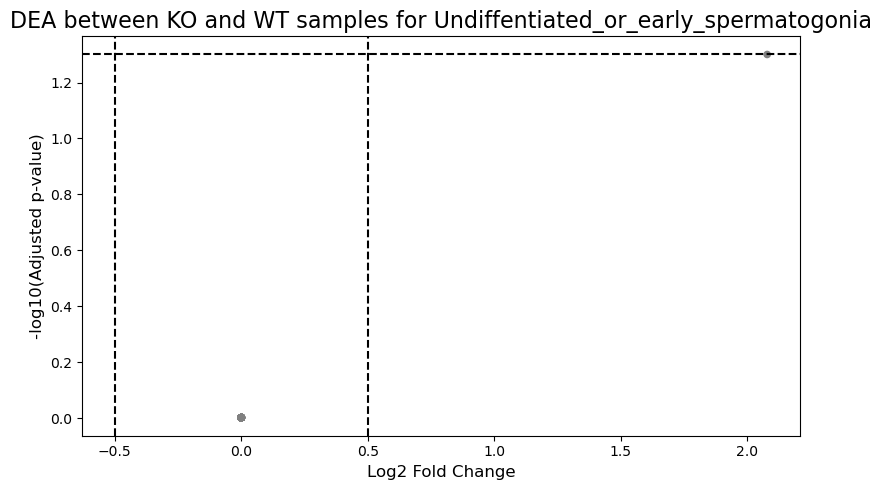

significantly DE genes for  Undiffentiated_or_early_spermatogonia , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.15 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.30 seconds.

Fitting LFCs...
... done in 0.12 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.04 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     9.337915        0.022985  0.771913  0.029777  0.976245  0.992602
1     8.473758       -0.077277  0.818709 -0.094389  0.924800  0.992602
2    11.071655       -0.137981  0.711531 -0.193921  0.846237  0.992602
3    12.107771        0.288753  0.678859  0.425351  0.670581  0.992602
4    12.987773        0.434464  0.656060  0.662233  0.507822  0.992602
..         ...             ...       ...       ...       ...       ...
145  22.937918       -0.128359  0.497340 -0.258090  0.796337  0.992602
146   9.489087        0.217699  0.787806  0.276335  0.782291  0.992602
147  15.094504       -0.121229  0.618479 -0.196011  0.844601  0.992602
148  11.495303       -0.045052  0.710280 -0.063428  0.949426  0.992602
149  13.341713        0.253353  0.671037  0.377554  0.705762  0.992602

[150 rows x 6 columns]


Fitting MAP LFCs...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/utils.py:1087: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
... done in 0.70 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0     9.337915   -3.626587e-08  0.001477  0.029777  0.976245  0.992602
1     8.473758    1.216364e-07  0.001474 -0.094389  0.924800  0.992602
2    11.071655    2.863828e-07  0.001501 -0.193921  0.846237  0.992602
3    12.107771   -6.588830e-07  0.001432  0.425351  0.670581  0.992602
4    12.987773   -1.046199e-06  0.001410  0.662233  0.507822  0.992602
..         ...             ...       ...       ...       ...       ...
145  22.937918    5.450001e-07  0.001500 -0.258090  0.796337  0.992602
146   9.489087   -3.660397e-07  0.001456  0.276335  0.782291  0.992602
147  15.094504    3.324261e-07  0.001506 -0.196011  0.844601  0.992602
148  11.495303    9.997035e-08  0.001495 -0.063428  0.949426  0.992602
149  13.341713   -5.185892e-07  0.001447  0.377554  0.705762  0.992602

[150 rows x 6 columns]


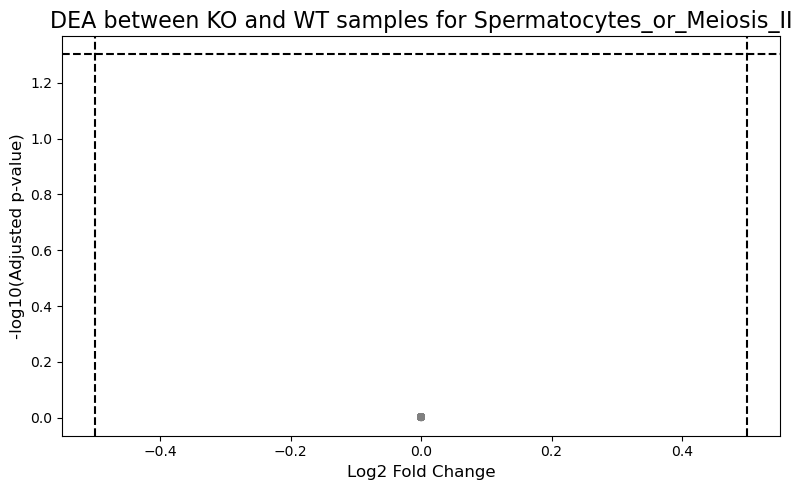

significantly DE genes for  Spermatocytes_or_Meiosis_II , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.16 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.32 seconds.

Fitting LFCs...
... done in 0.15 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.06 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.085234        0.180261  0.668699  0.269570  0.787491  0.994438
1    11.823314        0.222149  0.662018  0.335564  0.737200  0.994438
2    16.953201       -0.129092  0.616728 -0.209318  0.834200  0.994438
3     9.443930        0.024983  0.697943  0.035795  0.971446  0.994438
4     9.033663       -0.735486  0.718402 -1.023781  0.305939  0.994438
..         ...             ...       ...       ...       ...       ...
168  20.699614        0.192030  0.589880  0.325542  0.744771  0.994438
169  22.756377        0.070673  0.590343  0.119715  0.904709  0.994438
170  10.591342       -2.666488  0.768678 -3.468928  0.000523  0.090399
171  22.962086        0.027496  0.577891  0.047580  0.962051  0.994438
172  16.883063        0.371888  0.617230  0.602511  0.546834  0.994438

[173 rows x 6 columns]


... done in 0.72 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.085234   -4.202402e-07  0.001331  0.269570  0.787491  0.994438
1    11.823314   -5.289058e-07  0.001330  0.335564  0.737200  0.994438
2    16.953201    3.540612e-07  0.001383 -0.209318  0.834200  0.994438
3     9.443930   -6.555341e-08  0.001341  0.035795  0.971446  0.994438
4     9.033663    1.452790e-06  0.001420 -1.023781  0.305939  0.994438
..         ...             ...       ...       ...       ...       ...
168  20.699614   -5.731269e-07  0.001349  0.325542  0.744771  0.994438
169  22.756377   -2.073540e-07  0.001369  0.119715  0.904709  0.994438
170  10.591342    2.128702e+00  0.783222 -3.468928  0.000523  0.090399
171  22.962086   -9.482098e-08  0.001375  0.047580  0.962051  0.994438
172  16.883063   -1.006421e-06  0.001318  0.602511  0.546834  0.994438

[173 rows x 6 columns]


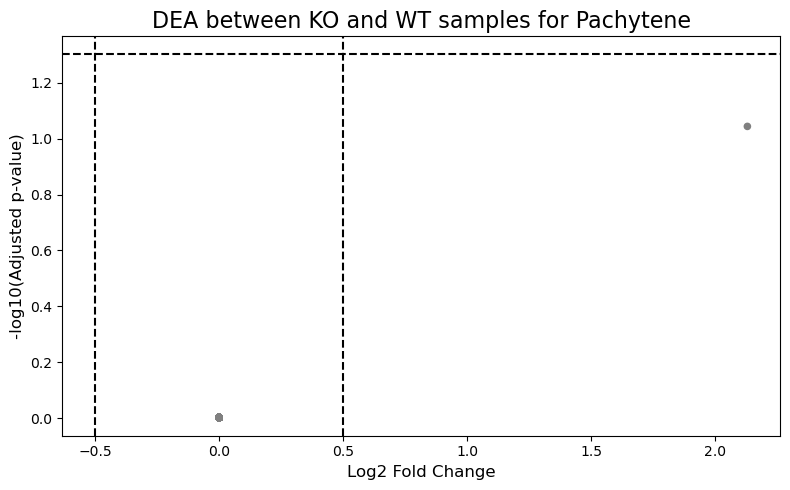

significantly DE genes for  Pachytene , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.02 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    10.314085        0.475256  0.734445  0.647096  0.517570  0.935867
1    15.338830        0.110918  0.710274  0.156162  0.875905  0.981989
2    14.232535        1.033604  0.733985  1.408208  0.159070  0.600930
3    10.065504        0.016482  0.730068  0.022576  0.981989  0.981989
4    11.182367       -0.823953  0.734946 -1.121108  0.262242  0.881495
5     8.877396       -3.866506  1.197571 -3.228625  0.001244  0.021146
6    18.950441       -0.679825  0.708132 -0.960025  0.337042  0.881495
7     9.847346        0.516198  0.756263  0.682564  0.494882  0.935867
8    31.634105        0.304108  0.677965  0.448560  0.653749  0.963593
9    16.199599        0.975291  0.674718  1.445479  0.148323  0.600930
10   11.777193        1.964130  0.769255  2.553288  0.010671  0.090705
11    8.975442       -2.805342  0.973695 -2.881128  0.003963  0.044909
12  225.064069

... done in 0.08 seconds.



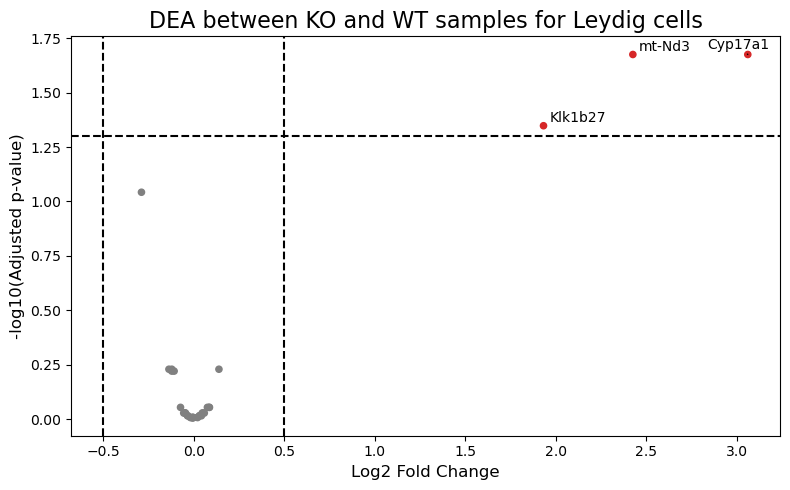

significantly DE genes for  Leydig cells , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.02 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.01 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   15.991813        0.494481  0.741509  0.666858  0.504863  0.673151
1   17.273909        1.675505  0.734760  2.280345  0.022587  0.090349
2   54.206953        0.361678  0.682981  0.529558  0.596419  0.745523
3   12.488924        1.105570  0.771612  1.432805  0.151914  0.379784
4   22.615174        0.898089  0.966860  0.928872  0.352956  0.588259
5   26.258293       -5.765011  1.596260 -3.611573  0.000304  0.006087
6   10.312560       -5.906954  2.492151 -2.370223  0.017777  0.090349
7   13.380209        0.859698  0.786180  1.093513  0.274169  0.517430
8   14.934078        0.854462  0.798508  1.070073  0.284586  0.517430
9   16.195459        2.687655  0.800570  3.357176  0.000787  0.007874
10   6.500067       -5.215456  2.491861 -2.092996  0.036350  0.121165
11  30.757527       -0.152073  0.675617 -0.225087  0.821911  0.865170
12  57.171072       -0.9149

Fitting MAP LFCs...
... done in 0.05 seconds.



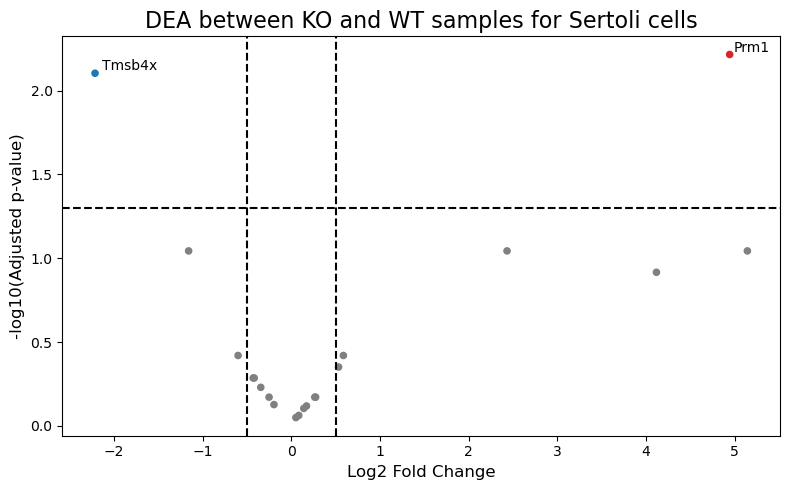

significantly DE genes for  Sertoli cells , intersected with bulk DEGs:
['Tmsb4x']
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.22 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.19 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.03 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.421137       -0.602079  1.352919 -0.445022  0.656304  0.969801
1    10.388078       -1.514854  1.343650 -1.127417  0.259566  0.930283
2     7.577529       -1.349438  1.362798 -0.990197  0.322078  0.930283
3     7.549149       -0.900717  1.356103 -0.664195  0.506566  0.936631
4    27.676918       -1.904456  1.335228 -1.426315  0.153778  0.930283
..         ...             ...       ...       ...       ...       ...
97   15.647651       -0.203119  1.196167 -0.169808  0.865161  0.969801
98   11.859002        1.584343  1.216883  1.301968  0.192927  0.930283
99    6.036748       -1.661980  1.406590 -1.181567  0.237377  0.930283
100   3.937340       -1.833318  1.488255 -1.231857  0.218002  0.930283
101   5.658215       -0.652552  1.385259 -0.471069  0.637592  0.969801

[102 rows x 6 columns]


... done in 0.52 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.WT]
      baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0    11.421137    3.635995e-07  0.001619 -0.445022  0.656304  0.969801
1    10.388078    8.883179e-07  0.001952 -1.127417  0.259566  0.930283
2     7.577529    7.837085e-07  0.001880 -0.990197  0.322078  0.930283
3     7.549149    5.703195e-07  0.001719 -0.664195  0.506566  0.936631
4    27.676918    1.010234e-06  0.002179 -1.426315  0.153778  0.930283
..         ...             ...       ...       ...       ...       ...
97   15.647651    1.565063e-07  0.001520 -0.169808  0.865161  0.969801
98   11.859002   -1.038482e-06  0.001242  1.301968  0.192927  0.930283
99    6.036748    8.975582e-07  0.001994 -1.181567  0.237377  0.930283
100   3.937340    8.154231e-07  0.002028 -1.231857  0.218002  0.930283
101   5.658215    3.806526e-07  0.001645 -0.471069  0.637592  0.969801

[102 rows x 6 columns]


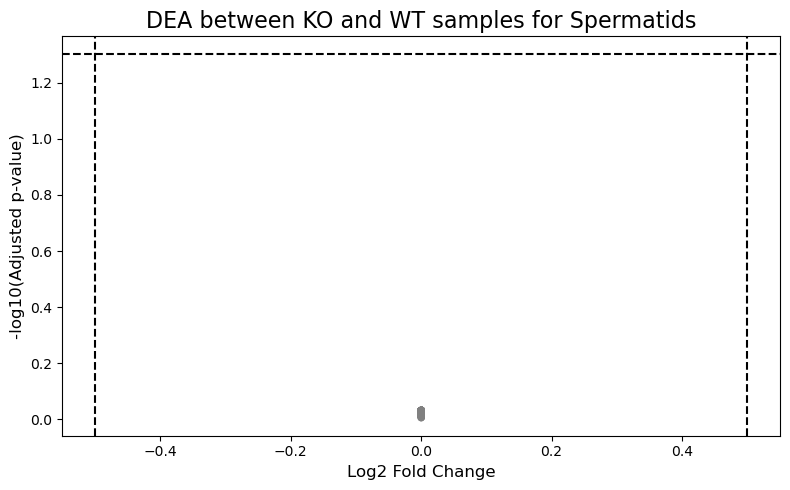

significantly DE genes for  Spermatids , intersected with bulk DEGs:
[]
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.45 seconds.

Fitting dispersion trend curve...
/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.03 seconds.

/home/eshipulina/miniconda3/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.64 seconds.

Fitting LFCs...
... done in 0.31 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.04 seconds.

Fitting 

There is no KO or WT samples for this cell type
Using None as control genes, passed at DeseqDataSet initialization


... done in 0.06 seconds.

Fitting LFCs...
... done in 0.03 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.01 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: condition Knockout vs WT
     baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0   19.238080        0.618937  1.135701  0.544982  0.585766  0.993457
1   41.061636       -0.553611  1.045335 -0.529602  0.596388  0.993457
2    8.447684        0.060456  1.160146  0.052111  0.958441  0.993457
3    7.029214        0.199632  1.213947  0.164449  0.869378  0.993457
4   10.853757       -0.038774  1.132253 -0.034245  0.972682  0.993457
5   15.507408        0.159947  1.100900  0.145288  0.884484  0.993457
6   16.412229        0.307570  1.107647  0.277679  0.781259  0.993457
7   15.291974        0.196265  1.104748  0.177656  0.858993  0.993457
8   20.833425       -0.211159  1.176871 -0.179424  0.857605  0.993457
9    8.186480       -0.024606  1.164715 -0.021127  0.983145  0.993457
10  13.725023       -0.202073  1.121557 -0.180172  0.857017  0.993457
11  40.106526       -0.295775  1.053097 -0.280862  0.778816  0.993457
12  30.114247       -7.3472

... done in 0.14 seconds.



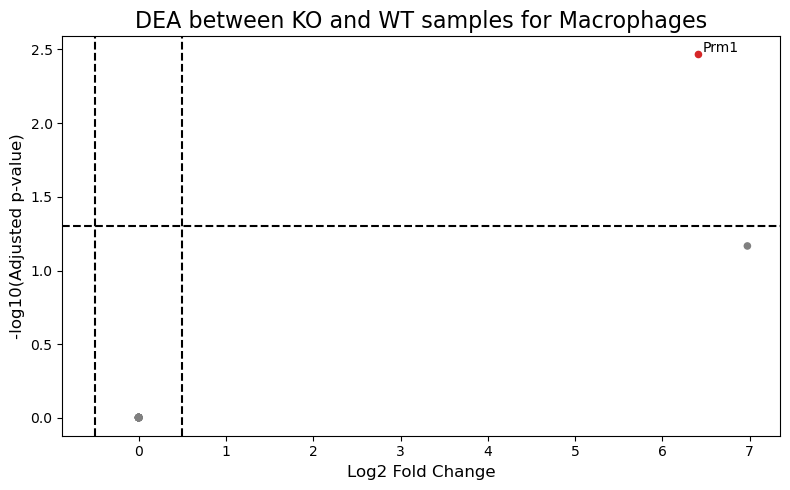

significantly DE genes for  Macrophages , intersected with bulk DEGs:
[]


In [34]:
for i in set(pdata.obs['joined_clust']):
    cell_type = pdata[pdata.obs['joined_clust'] == i].copy()
    genes = dc.filter_by_expr(cell_type, group='condition', min_count=10, min_total_count=15)

    # Filter by these genes
    cell_type = cell_type[:, genes].copy()
    cell_type.X = cell_type.X.round().astype(int)
    # Build DESeq2 object
    inference = DefaultInference(n_cpus=1)
    dds = DeseqDataSet(
        counts=cell_type.X,
        metadata=cell_type.obs,
        design='~condition',
        refit_cooks=True,
        inference=inference,
    )
    # Compute LFCs
    dds.deseq2()

    if 'Knockout' not in set(dds.obs['condition']) or 'WT' not in set(dds.obs['condition']):
        print('There is no KO or WT samples for this cell type')
        continue
    
    # Extract contrast between KO and WT
    ds_KO_vs_WT = DeseqStats(
        dds,
        contrast=["condition", 'Knockout', 'WT'],
        inference=inference,
    )
    # Compute Wald test
    ds_KO_vs_WT.summary()
    ds_KO_vs_WT.lfc_shrink(coeff="condition[T.WT]")
    results_df = ds_KO_vs_WT.results_df
    results_df.index = cell_type.var.index

    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 5)
    )

    title = 'DEA between KO and WT samples for ' + i
    plt.title(title, fontsize=16)
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-log10(Adjusted p-value)', fontsize=12)
    
    plt.tight_layout()
    path = f'./pseudobulk_DEGs/mean_mode_all_stages{i}.png'
    plt.savefig(path, dpi=300)
    plt.show()

    
    significant = results_df[abs(results_df['padj']) < 0.05]
    singlecell = significant.index
    sc_bulk_intersection = list(set(singlecell) & set(bulk['x']))

    print('significantly DE genes for ', i, ', intersected with bulk DEGs:')
    print(sc_bulk_intersection)
    
    dict_to_save = {i: sc_bulk_intersection}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_bulk_intersected_DEGs_for_mean_mode_all_stages'+i+'.csv'
    df.to_csv(path, index=False)

    dict_to_save = {i: singlecell}
    df = pd.DataFrame(dict_to_save)
    path = './pseudobulk_DEGs/sc_DEGs_for_mean_mode_all_stages'+i+'.csv'
    df.to_csv(path, index=False)